In [1]:
if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    drive.mount('/content/drive')
    %cd /content/drive/MyDrive/polar-lows-detection-forecasting-deep-learning/additional_notebooks/
    !pip install pytorch-lightning
    !pip install captum
    !pip install timm
    !pip install torchinfo

In [2]:
import os
import sys
import cv2
from pathlib import Path

root_dir = Path('..').resolve() # resolve() is used to get the absolute path of the directory
sys.path.insert(0, str(root_dir))

import numpy as np
import random
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image

import config
from data_loader import create_data_loaders, get_transforms
from image_utility import normalize_image
from model_container import ModelContainer
from models import XceptionModel

/home/andrea/anaconda3/envs/polar_lows_dl/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
path_prefix = '../'
root = Path(path_prefix)

In [4]:
batch_size = 1
_, val_loader, _ = create_data_loaders(root / config.train_dir, root / config.test_dir, config.resized_image_res, batch_size, config.num_workers)

torch_model = XceptionModel(num_classes=2)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, torch_model.parameters()), lr=0.001)

model = ModelContainer.load_from_checkpoint(root / 'checkpoints' / 'xception-oct-13.ckpt', model=torch_model, criterion=criterion, optimizer=optimizer)

_, data_prep = get_transforms(config.resized_image_res)

/home/andrea/anaconda3/envs/polar_lows_dl/lib/python3.12/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/home/andrea/anaconda3/envs/polar_lows_dl/lib/python3.12/site-packages/timm/models/_factory.py:117: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(
/home/andrea/anaconda3/envs/polar_lows_dl/lib/python3.12/site-packages/torch/cuda/__init__.py:716: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [5]:
precalculated_ig = True

if precalculated_ig:
    image_path = root / 'data' / 'train' / 'pos' / '082f07_20190311T024310_20190311T024414_mos_rgb.png'
else:
    pos_dir = os.path.join(root / config.train_dir, 'pos') # Directory of 'pos' images
    chosen_image = random.choice(os.listdir(pos_dir))
    image_path = os.path.join(pos_dir, chosen_image)

    # image_path = root / 'data/train/pos/6e0d07_20161005T084729_20161005T084924_mos_rgb.png'

# Prepare image
original_image = Image.open(image_path).convert('RGB')
transformed_image = data_prep(original_image).unsqueeze(0)

if precalculated_ig:
    heatmap = np.load(root / 'local_test_files' / 'heatmap_train_pos_082f07_20190311T024310_20190311T024414_mos_rgb.npy')
    predicted_class = 1
else:
    heatmap, predicted_class = model.generate_integrated_gradients_heatmap(transformed_image)

    # np.save(root / 'local_test_files' / 'heatmap_train_pos_082f07_20190311T024310_20190311T024414_mos_rgb.npy', heatmap)

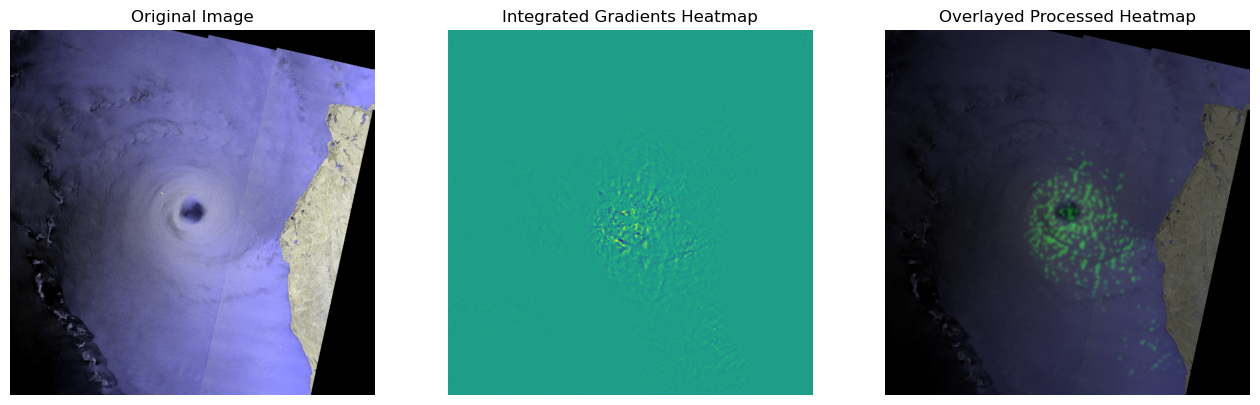

Image path: ../data/train/pos/082f07_20190311T024310_20190311T024414_mos_rgb.png


In [6]:
plt.figure(figsize=(16, 8))

# Original image
plt.subplot(1, 3, 1) # plt.subplot(num_rows, num_columns, index)
plt.imshow(original_image)
plt.title('Original Image')
plt.axis('off')

# Integrated Gradients heatmap
plt.subplot(1, 3, 2)
plt.imshow(heatmap)
plt.title('Integrated Gradients Heatmap')
plt.axis('off')

ig_overlayed = model.overlay_green_heatmap(original_image, heatmap, predicted_class)
# Overlay heatmap on original image
plt.subplot(1, 3, 3)
plt.imshow(ig_overlayed)
plt.title('Overlayed Processed Heatmap')
plt.axis('off')

plt.show()


# Print additional info

print(f'Image path: {image_path}') # Print image path

In order to generate the mask for the hurricane, we first resize the heatmap to match the size of the original image.

INTER_LINEAR interpolation is used for upscaling an image, and it calculates the pixel value at a new position based on a weighted average of the four nearest pixels in the input image. The weights for the four pixels are based on their proximity to the new pixel location.

(-0.5, 298.5, 298.5, -0.5)

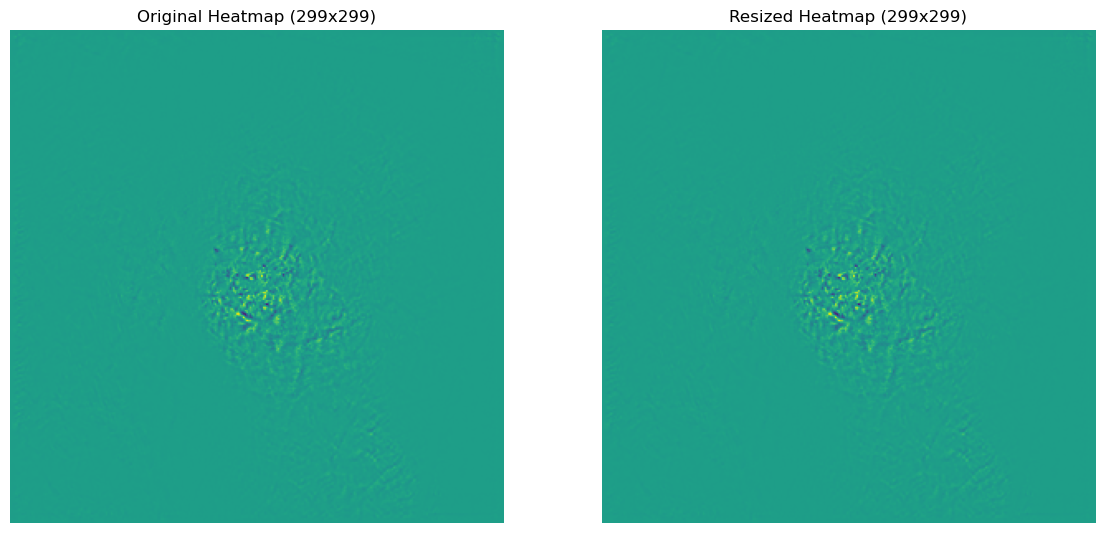

In [7]:
original_size = transformed_image.shape[2:] # Original image size
heatmap_resized = cv2.resize(heatmap, (original_size[1], original_size[0]), interpolation=cv2.INTER_LINEAR)

plt.figure(figsize=(14, 8))

# Initial heatmap
plt.subplot(1, 2, 1)
plt.imshow(heatmap)
plt.title(f'Original Heatmap ({original_size[1]}x{original_size[0]})')
plt.axis('off')

# Resized heatmap
plt.subplot(1, 2, 2)
plt.imshow(heatmap)
plt.title(f'Resized Heatmap ({heatmap_resized.shape[1]}x{heatmap_resized.shape[0]})')
plt.axis('off')

We then binarize the heatmap based on a threshold value. In this case, the threshold in automatically calculated using the percentile.

(-0.5, 298.5, 298.5, -0.5)

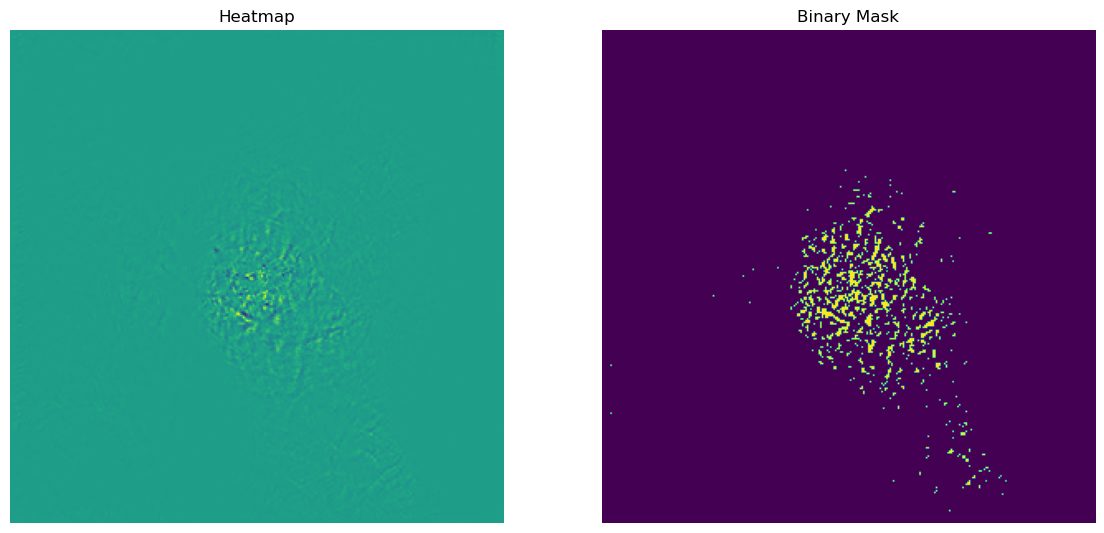

In [8]:
percentile = 98

# Flatten the heatmap
heatmap_flattened = heatmap_resized.flatten()

# Calculate the threshold based on the percentile
threshold = np.percentile(heatmap_flattened, percentile)

# Binarize the heatmap using the specified threshold
binary_mask = np.where(heatmap_resized >= threshold, 1, 0).astype(np.uint8)

plt.figure(figsize=(14, 8))

# Heatmap
plt.subplot(1, 2, 1)
plt.imshow(heatmap_resized)
plt.title('Heatmap')
plt.axis('off')

# Binary mask
plt.subplot(1, 2, 2)
plt.imshow(binary_mask)
plt.title('Binary Mask')
plt.axis('off')

We now apply **Morphological Closing** (cv2.MORPH_CLOSE) to the binary mask.

Morphological closing is composed of two steps:
1. **Dilation**: Dilation expands the boundaries of the foreground (white) regions in the binary image. It works by placing a structuring element (kernel in this case) over each white pixel and growing the object based on this kernel.
2. **Erosion**: Erosion shrinks the boundaries of the foreground regions eroding away the outer layer of pixels. For each pixel, if even a single pixel within the kernel's region is background, the pixel in the output is set to the background value (0). Erosion is useful for removing small noise.

(-0.5, 298.5, 298.5, -0.5)

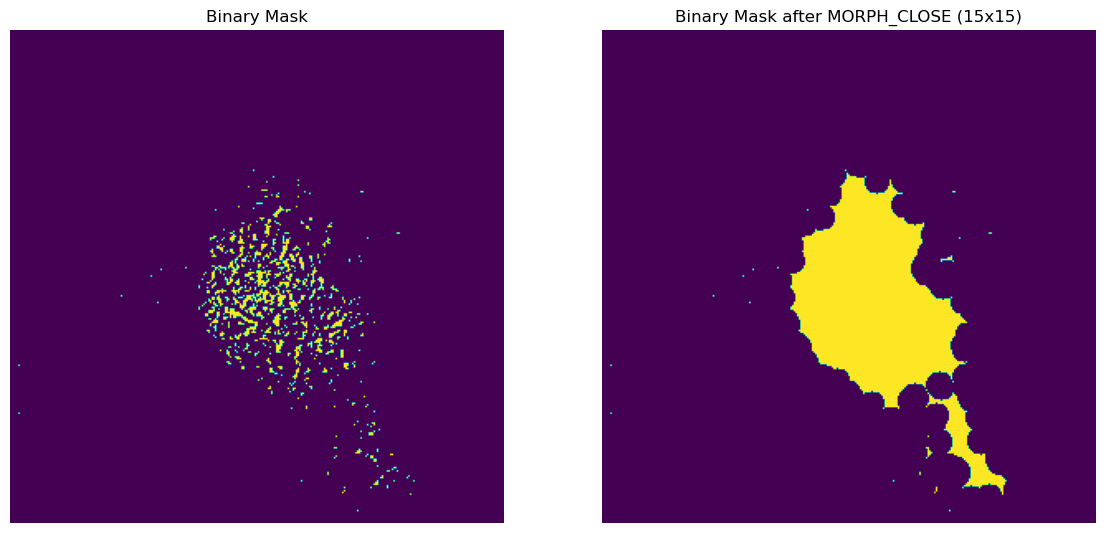

In [9]:
kernel_size = (15, 15)

kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, kernel_size)
closed_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_CLOSE, kernel)

plt.figure(figsize=(14, 8))

# Binary mask
plt.subplot(1, 2, 1)
plt.imshow(binary_mask)
plt.title('Binary Mask')
plt.axis('off')

# Binary mask after MORPH_CLOSE
plt.subplot(1, 2, 2)
plt.imshow(closed_mask)
plt.title(f'Binary Mask after MORPH_CLOSE ({kernel_size[0]}x{kernel_size[1]})')
plt.axis('off')

We apply Gaussian blur to smooth edges. This also removes isolated points.

(-0.5, 298.5, 298.5, -0.5)

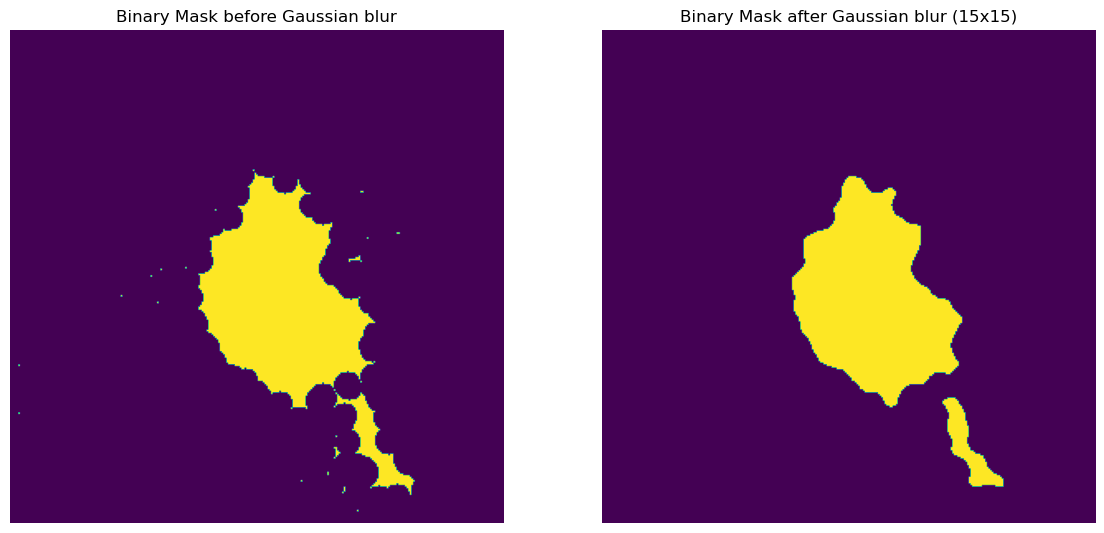

In [10]:
gb1_size = (15, 15)

blurred_mask = cv2.GaussianBlur(closed_mask, gb1_size, 0)

plt.figure(figsize=(14, 8))

# Binary mask before Gaussian blur
plt.subplot(1, 2, 1)
plt.imshow(closed_mask)
plt.title('Binary Mask before Gaussian blur')
plt.axis('off')

# Binary mask after MORPH_CLOSE
plt.subplot(1, 2, 2)
plt.imshow(blurred_mask)
plt.title(f'Binary Mask after Gaussian blur ({gb1_size[0]}x{gb1_size[1]})')
plt.axis('off')

Here we apply **Area Opening**: Small objects with area smaller than a set minimum are removed.

We set the minimum area equal to a fraction of the biggest area in the mask.

RETR_EXTERNAL: Retrieves only the outermost contours. Inner contours are ignored.

CHAIN_APPROX_SIMPLE: This flag compresses horizontal, vertical, and diagonal segments and only keeps their end points. It reduces the number of points needed to store the contour, saving memory.

Parameters of cv2.drawContours:
- `closed_mask`: The image where the contours will be drawn.
- `[contour]`: This specified the contour to draw. It is wrapped in a list because `cv2.drawContours()` expects a list of contours.
- `-1`: This indicates that the entire contour should be filled.
- `0`: The color value to fill the contour with.
- `-1`: This thickness value indicates filling the contour.

(-0.5, 298.5, 298.5, -0.5)

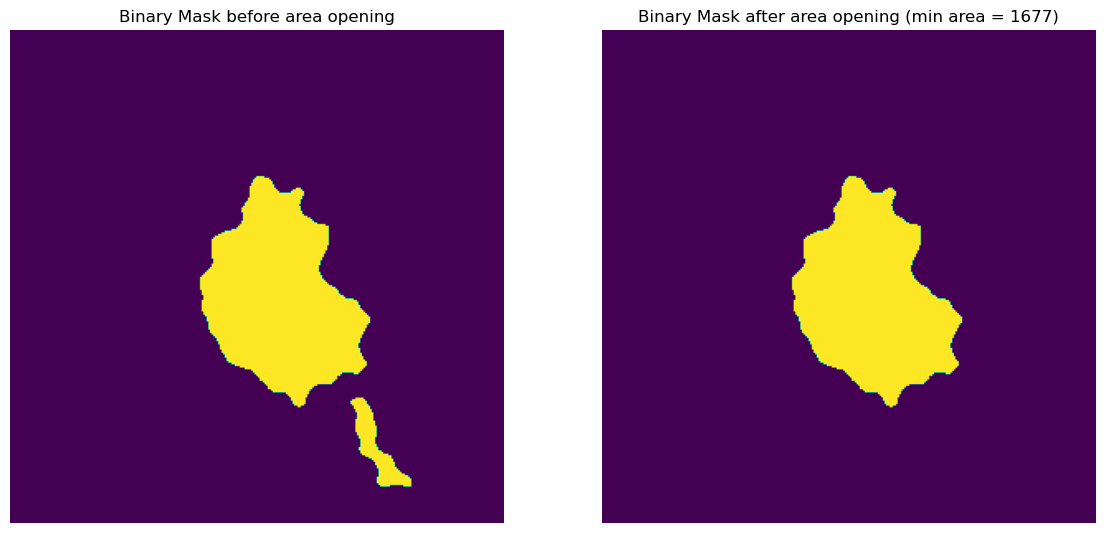

In [11]:
fraction_of_biggest = 0.2

ao_mask = blurred_mask.copy()
contours, _ = cv2.findContours(blurred_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Calculate area of each contour
areas = [cv2.contourArea(contour) for contour in contours]

# Determine the minimum area to keep
if areas:
    max_area = max(areas)
    min_area = max_area * fraction_of_biggest
else:
    min_area = 0 # No contours found

for contour in contours:
    if cv2.contourArea(contour) < min_area:
        cv2.drawContours(ao_mask, [contour], -1, 0, -1)

plt.figure(figsize=(14, 8))

# Binary mask before area opening
plt.subplot(1, 2, 1)
plt.imshow(blurred_mask)
plt.title('Binary Mask before area opening')
plt.axis('off')

# Binary mask after area opening
plt.subplot(1, 2, 2)
plt.imshow(ao_mask)
plt.title(f'Binary Mask after area opening (min area = {min_area:.0f})')
plt.axis('off')

Finally, we apply Gaussian blur a second time to make the final mask smoother.

(-0.5, 298.5, 298.5, -0.5)

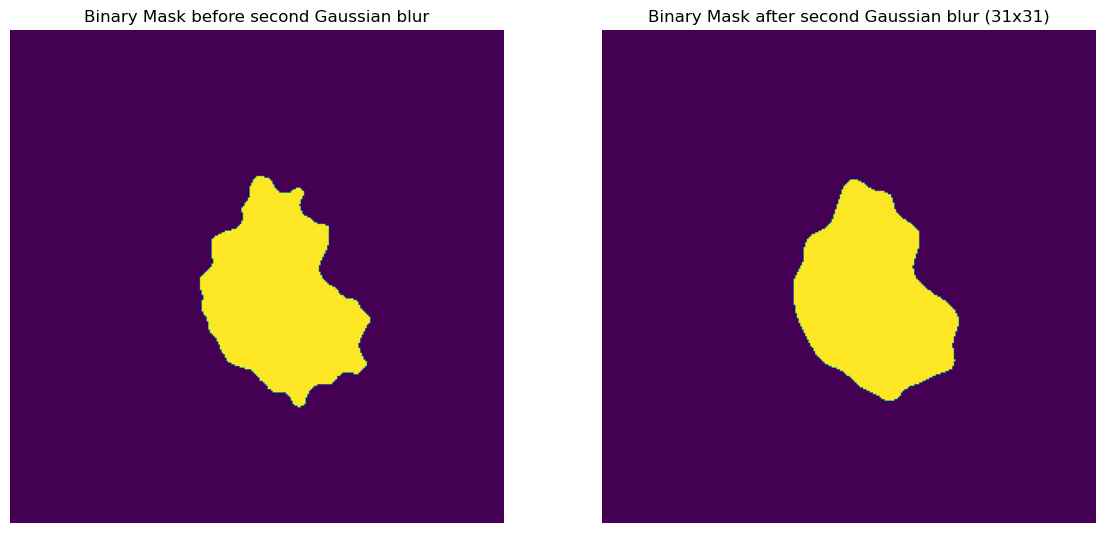

In [12]:
gb2_size = (31, 31) # Remember that the kernel size must be odd

final_mask = cv2.GaussianBlur(ao_mask, gb2_size, 0)

plt.figure(figsize=(14, 8))

# Binary mask before Gaussian blur
plt.subplot(1, 2, 1)
plt.imshow(ao_mask)
plt.title('Binary Mask before second Gaussian blur')
plt.axis('off')

# Binary mask after MORPH_CLOSE
plt.subplot(1, 2, 2)
plt.imshow(final_mask)
plt.title(f'Binary Mask after second Gaussian blur ({gb2_size[0]}x{gb2_size[1]})')
plt.axis('off')

We now overlay the mask on the original image.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..65.49817].


(-0.5, 298.5, 298.5, -0.5)

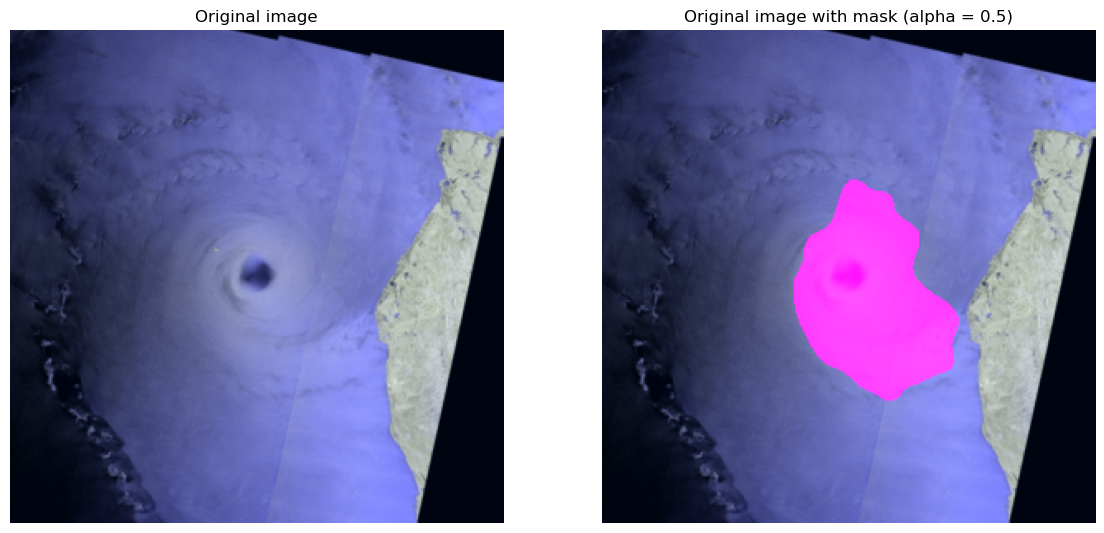

In [13]:
alpha = 0.5

img_np = transformed_image.squeeze(0).permute(1, 2, 0).numpy() # Squeeze the batch dimension and permute to get shape (H, W, C)
img_np = normalize_image(img_np, target_range=(0, 1)) # Normalize the image to [0, 1]

# Create a color overlay from the binary mask
color_overlay = np.zeros_like(img_np)
color_overlay[final_mask == 1] = [75, 0, 130]

# Blend the original image with the color overlay
image_with_mask = img_np.copy()
image_with_mask[final_mask == 1] = cv2.addWeighted(
    color_overlay[final_mask == 1],
    alpha,
    img_np[final_mask == 1],
    1 - alpha,
    0
)

plt.figure(figsize=(14, 8))

# Original image
plt.subplot(1, 2, 1)
plt.imshow(img_np)
plt.title('Original image')
plt.axis('off')

# Binary mask after MORPH_CLOSE
plt.subplot(1, 2, 2)
plt.imshow(image_with_mask)
plt.title(f'Original image with mask (alpha = {alpha})')
plt.axis('off')